# Region-specific aging clocks

This notebook generates statistics and plots for evaluating and comparing spatial aging clocks that are trained and applied within specific regions only. The region-specific clocks are compared to the main global aging clock. Training and cross-validation of region-specific aging clocks are done in `clocks_regional.py` and `clocks_regional_applyall.py` and is needed as inputs for this notebook.

**Associated manuscript figures/tables:**
- Extended Data Figures: 5e,f,g


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)
- `results/clocks/anndata/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with region-specific spatial aging clock predictions (generated from `clocks_regional.py`)
- `results/clocks/anndata/RESTRICTED*_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.h5ad` - AnnData objects for coronal sections data with region-specific spatial aging clock predictions in a region-restricted manner (generated from `clocks_regional_applyall.py`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns

from clock_preprocessing import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

## SpatialSmooth (soft pseudobulking)

In [3]:
adata = sc.read_h5ad("results/clocks/anndata/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.h5ad")

In [ ]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Lasso, Leave-Mouse-Out-CV", fontsize=16)
fig.supxlabel("Chronological Age (months)", fontsize=16)
fig.supylabel("Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth.pdf",
            dpi=300, bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv", index=False)

In [5]:
adata = sc.read_h5ad("results/clocks/anndata/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.h5ad")

In [ ]:
# save for each region
nrows = 2
ncols = 9

for region in np.unique(adata.obs.region):
    
    s_adata = adata[adata.obs.region==region,:].copy()
    
    fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

    celltype_list = []
    r_list = []
    mae_list = []

    counter = 0
    for i in range(nrows):
        for j in range(ncols):

            celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
            
            sub_adata = s_adata[s_adata.obs["celltype"]==celltype,:]
            
            if sub_adata.shape[0] < 2:
                counter += 1            
            
            else:
                # make plot
                axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
                axs[i,j].set_title(celltype)
                r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
                mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
                axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)

                # append stats
                celltype_list.append(celltype)
                r_list.append(r)
                mae_list.append(mae)

                counter += 1


    # save stats
    regi = region.split("/")[0]
    stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
    stat_df.to_csv(f"results/clocks/stats/REGION_{regi}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv", index=False)

## Dot plot comparing region-specific and global (main) spatial aging clocks

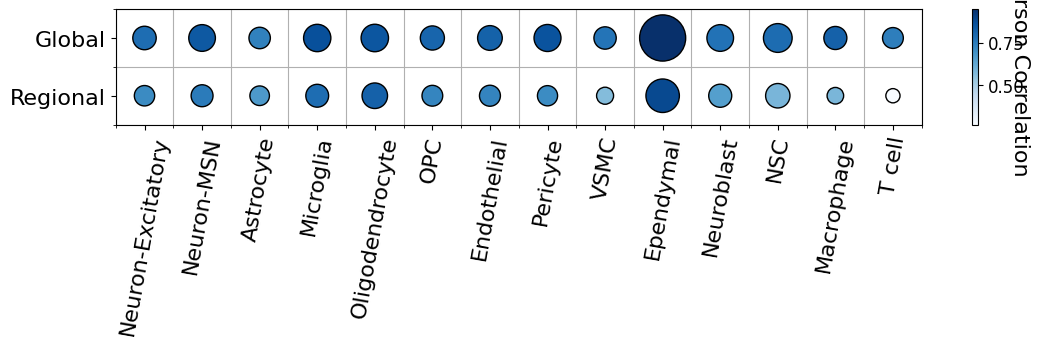

In [10]:
filepaths = ["results/clocks/stats/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
            "results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",]
names = ["Regional", "Global"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.savefig("plots/clocks/comparison_train_test_same_Global_Regional.pdf", bbox_inches='tight')
plt.show()

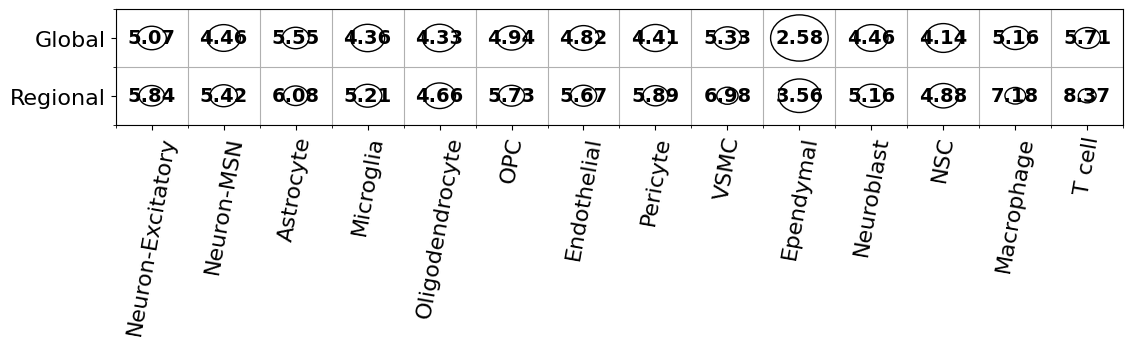

In [6]:
# PRINT LABELS FOR SIZE LEGEND

filepaths = ["results/clocks/stats/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
            "results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",]
names = ["Regional", "Global"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
# Create circles and annotate with mean_abs_err values
for r, j, i, value in zip(R.flat, x.flat, y.flat, comb_df["mean_abs_err"].values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=14)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')


#plt.tight_layout()
plt.show()

## Cross-region clock performance

In [3]:
for reg in ['CC/ACO', 'CTX_L1/MEN', 'CTX_L2/3', 'CTX_L4/5/6', 'STR_CP/ACB',
       'STR_LS/NDB', 'VEN']:
    
    # read in restricted region clock anndata
    adata = sc.read_h5ad(f"results/clocks/anndata/RESTRICTED{reg.split('/')[0]}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.h5ad")
    
    # exclude target region (and other nan predictions)
    adata = adata[~np.isnan(adata.obs.predicted_age)].copy()
    
    # compute statistics
    celltype_list = []
    r_list = []
    mae_list = []

    for celltype in list(pd.unique(adata.obs.celltype).sort_values()):
        
        sub_adata = adata[adata.obs["celltype"]==celltype,:]

        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))

        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
    
    del adata
    import gc
    gc.collect()
    
    # save stats
    stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
    stat_df.to_csv(f"results/clocks/stats/RESTRICTED{reg.split('/')[0]}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv", index=False)

In [4]:
ct_pearsons = {}
ct_maes = {}

# get all region restricted statistics
for reg in ['CC/ACO', 'CTX_L1/MEN', 'CTX_L2/3', 'CTX_L4/5/6', 'STR_CP/ACB',
       'STR_LS/NDB', 'VEN']:
        
        # read in stats df
        df = pd.read_csv(f"results/clocks/stats/RESTRICTED{reg.split('/')[0]}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv")
        
        for celltype in np.unique(df["celltype"]):
        
            # set up new keys
            if celltype not in ct_pearsons.keys():
                ct_pearsons[celltype] = []
            if celltype not in ct_maes.keys():
                ct_maes[celltype] = []

            # get stats
            ct_pearsons[celltype].append(df[df["celltype"]==celltype]["pearson"].values[0])
            ct_maes[celltype].append(df[df["celltype"]==celltype]["mean_abs_err"].values[0])
            
celltype_list = np.unique(list(ct_pearsons.keys()))
r_list = [np.nanmean(ct_pearsons[ct]) for ct in celltype_list]
mae_list = [np.nanmean(ct_maes[ct]) for ct in celltype_list]

stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])         
stat_df.to_csv(f"results/clocks/stats/RESTRICTEDAVERAGED_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv", index=False)

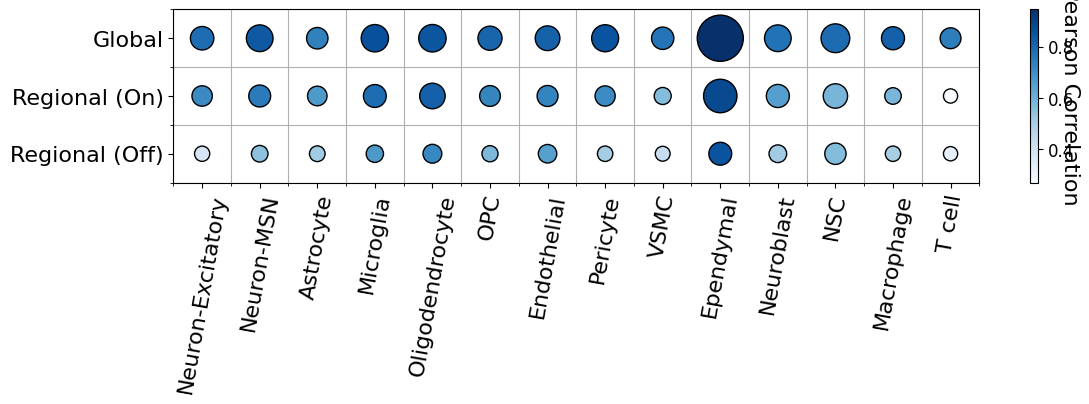

In [5]:
filepaths = ["results/clocks/stats/RESTRICTEDAVERAGED_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
    "results/clocks/stats/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
            "results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",]
names = ["Regional (Off)", "Regional (On)", "Global"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,2.25))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


#plt.tight_layout()
plt.savefig("plots/clocks/comparison_train_test_same_Global_Regional_ONOFF.pdf", bbox_inches='tight')
plt.show()

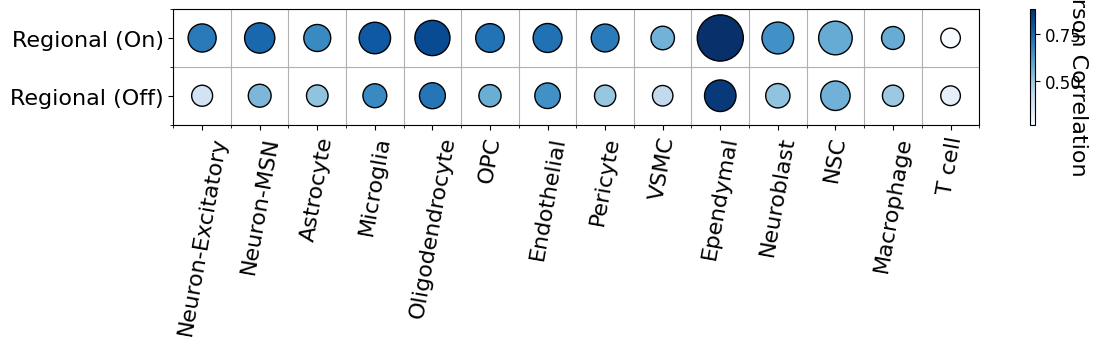

In [9]:
filepaths = ["results/clocks/stats/RESTRICTEDAVERAGED_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
    "results/clocks/stats/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
]
names = ["Regional (Off)", "Regional (On)"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


#plt.tight_layout()
plt.savefig("plots/clocks/comparison_train_test_same_Regional_ONOFF.pdf", bbox_inches='tight')
plt.show()

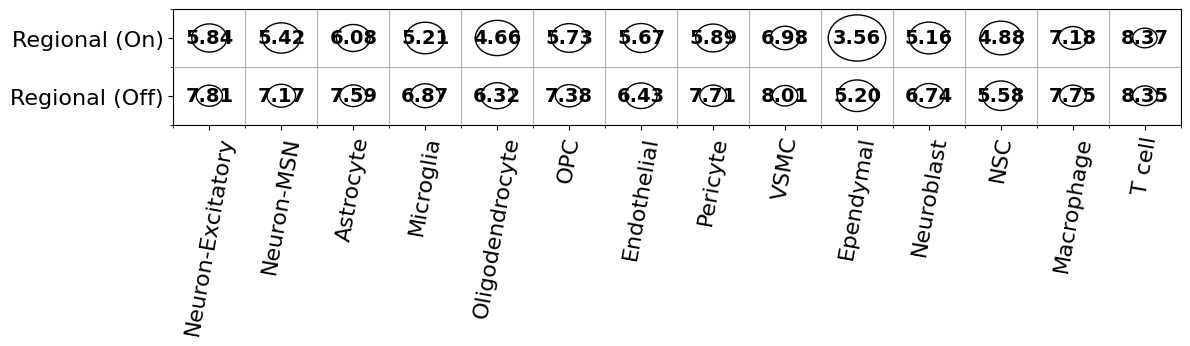

In [10]:
# PRINT LABELS FOR SIZE LEGEND

filepaths = ["results/clocks/stats/RESTRICTEDAVERAGED_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
    "results/clocks/stats/REGION_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh5.csv",
]
names = ["Regional (Off)", "Regional (On)"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
# Create circles and annotate with mean_abs_err values
for r, j, i, value in zip(R.flat, x.flat, y.flat, comb_df["mean_abs_err"].values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=14)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')


#plt.tight_layout()
plt.show()